In [1]:
from scipy.stats import spearmanr, pearsonr

from bertscore import BERTScore
from conventional_metrics import BLEU, METEOR
from scm import SCM, ContextualSCM, DecontextualizedSCM
from wmd import WMD, ContextualWMD, DecontextualizedWMD
from common import Evaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Mutual correlations of metrics

In [2]:
from pathlib import Path

if not (Path('embeddings')/'cc.en.300.bin').exists():
    %mkdir -p embeddings
    ! wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -O embeddings/cc.en.300.bin.gz
    ! gzip -d embeddings/cc.en.300.bin.gz

[nltk_data] Downloading package wordnet to /home/xnovot32/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xnovot32/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading pack

Evaluating lang pair cs-en


WMD_contextual: construct contextual embeddings:   0%|          | 0/1120 [00:00<?, ?it/s]

WMD_decontextualized: construct decontextualized embeddings:   0%|          | 0/4976 [00:00<?, ?it/s]

WMD_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/4976 [00:00<?, ?it/s]

SCM_decontextualized: construct decontextualized embeddings:   0%|          | 0/4976 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4976/4976 [00:11<00:00, 429.97it/s]


SCM_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/4976 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4976/4976 [00:16<00:00, 296.71it/s]


SCM:   0%|          | 0/560 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3820/3820 [03:54<00:00, 16.29it/s]


SCM_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3820/3820 [04:02<00:00, 15.76it/s]


WMD:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_contextual:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_decontextualized:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_decontextualized_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_decontextualized:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_decontextualized_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

BLEU:   0%|          | 0/560 [00:00<?, ?it/s]

METEOR:   0%|          | 0/560 [00:00<?, ?it/s]

BERTScore:   0%|          | 0/17 [00:00<?, ?it/s]

SCM:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

WMD:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

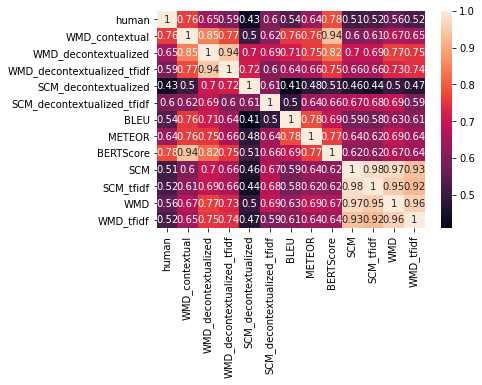

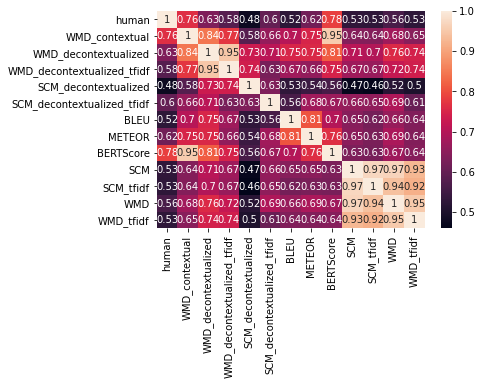

Evaluating lang pair de-en


WMD_contextual: construct contextual embeddings:   0%|          | 0/1120 [00:00<?, ?it/s]

WMD_decontextualized: construct decontextualized embeddings:   0%|          | 0/4880 [00:00<?, ?it/s]

WMD_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/4880 [00:00<?, ?it/s]

SCM_decontextualized: construct decontextualized embeddings:   0%|          | 0/4880 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4880/4880 [00:28<00:00, 169.33it/s]


SCM_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/4880 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4880/4880 [00:27<00:00, 180.21it/s]


SCM:   0%|          | 0/560 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3612/3612 [04:57<00:00, 12.14it/s]


SCM_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3612/3612 [03:40<00:00, 16.36it/s]


WMD:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_contextual:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_decontextualized:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_decontextualized_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_decontextualized:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_decontextualized_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

BLEU:   0%|          | 0/560 [00:00<?, ?it/s]

METEOR:   0%|          | 0/560 [00:00<?, ?it/s]

BERTScore:   0%|          | 0/17 [00:00<?, ?it/s]

SCM:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

WMD:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

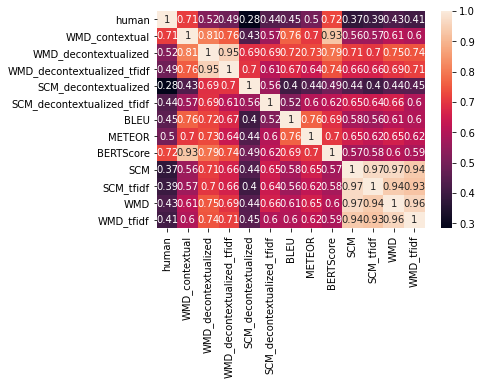

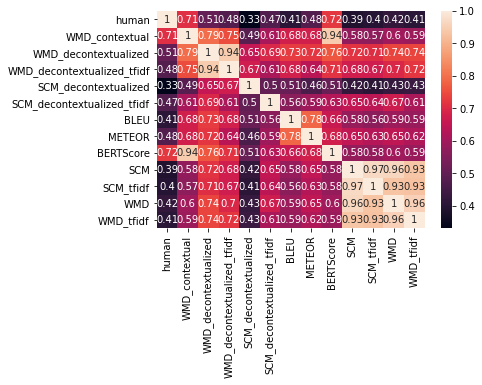

Evaluating lang pair fi-en


WMD_contextual: construct contextual embeddings:   0%|          | 0/1120 [00:00<?, ?it/s]

WMD_decontextualized: construct decontextualized embeddings:   0%|          | 0/5230 [00:00<?, ?it/s]

WMD_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/5230 [00:00<?, ?it/s]

SCM_decontextualized: construct decontextualized embeddings:   0%|          | 0/5230 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5230/5230 [00:31<00:00, 166.11it/s]


SCM_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/5230 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5230/5230 [00:28<00:00, 183.71it/s]


SCM:   0%|          | 0/560 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3922/3922 [05:10<00:00, 12.64it/s]


SCM_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3922/3922 [03:31<00:00, 18.57it/s]


WMD:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_contextual:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_decontextualized:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_decontextualized_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_decontextualized:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_decontextualized_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

BLEU:   0%|          | 0/560 [00:00<?, ?it/s]

METEOR:   0%|          | 0/560 [00:00<?, ?it/s]

BERTScore:   0%|          | 0/17 [00:00<?, ?it/s]

SCM:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

WMD:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

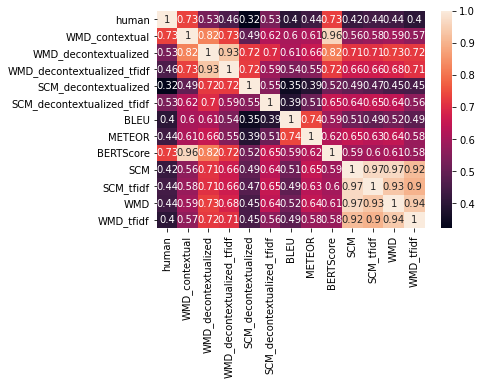

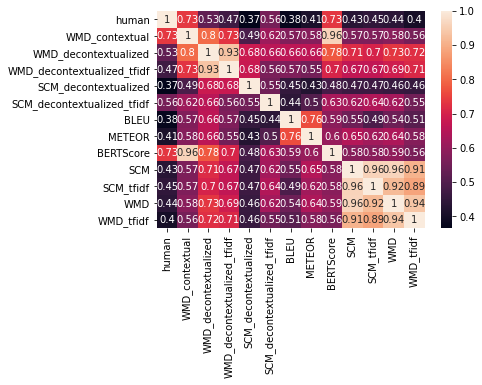

Evaluating lang pair ru-en


WMD_contextual: construct contextual embeddings:   0%|          | 0/1120 [00:00<?, ?it/s]

WMD_decontextualized: construct decontextualized embeddings:   0%|          | 0/5516 [00:00<?, ?it/s]

WMD_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/5516 [00:00<?, ?it/s]

SCM_decontextualized: construct decontextualized embeddings:   0%|          | 0/5516 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5516/5516 [00:21<00:00, 255.57it/s]


SCM_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/5516 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5516/5516 [00:19<00:00, 282.50it/s]


SCM:   0%|          | 0/560 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4228/4228 [04:13<00:00, 16.68it/s]


SCM_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4228/4228 [04:54<00:00, 14.35it/s]


WMD:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_contextual:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_decontextualized:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_decontextualized_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_decontextualized:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_decontextualized_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

BLEU:   0%|          | 0/560 [00:00<?, ?it/s]

METEOR:   0%|          | 0/560 [00:00<?, ?it/s]

BERTScore:   0%|          | 0/17 [00:00<?, ?it/s]

SCM:   0%|          | 0/560 [00:00<?, ?it/s]

SCM_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

WMD:   0%|          | 0/560 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/560 [00:00<?, ?it/s]

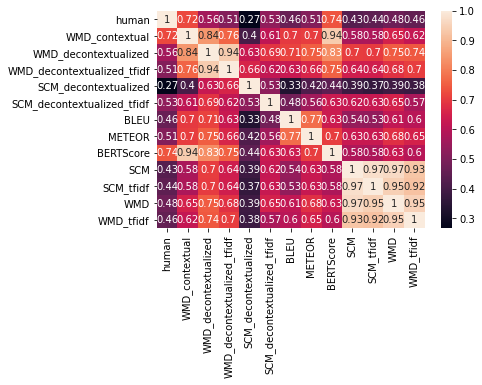

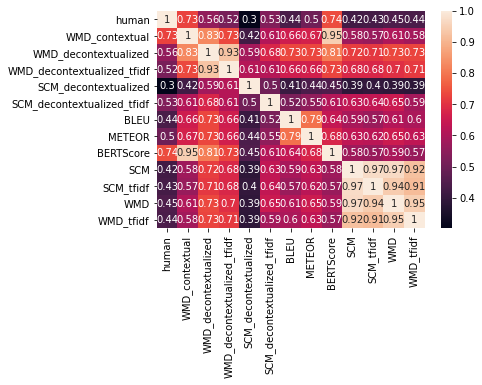

CPU times: user 10h 47min 20s, sys: 22h 6min 15s, total: 1d 8h 53min 35s
Wall time: 1h 6min 46s


In [3]:
%%time

metrics = [
    ContextualWMD(tgt_lang="en"),
    # ContextualSCM(tgt_lang="en"),
    DecontextualizedWMD(tgt_lang="en", use_tfidf=False),
    DecontextualizedWMD(tgt_lang="en", use_tfidf=True),
    DecontextualizedSCM(tgt_lang="en", use_tfidf=False),
    DecontextualizedSCM(tgt_lang="en", use_tfidf=True),
    BLEU(),
    METEOR(),
    BERTScore(tgt_lang="en"),
    SCM(tgt_lang="en", use_tfidf=False),
    SCM(tgt_lang="en", use_tfidf=True),
    WMD(tgt_lang="en", use_tfidf=False),
    WMD(tgt_lang="en", use_tfidf=True),
]

correlations = {m.label: {} for m in metrics}
correlations["human"] = {}

correlations_p = correlations.copy()
reports = []
langs = Evaluator.langs

selected_lang_pairs = [pair for pair in langs if pair.split("-")[-1] == "en"]

for lang_pair in selected_lang_pairs:
    print("Evaluating lang pair %s" % lang_pair)
    evaluator = Evaluator("data_dir", lang_pair, metrics, judgements_type="DA", firstn=None)
    report = evaluator.evaluate()
    reports.append(report)

    human_judgements = report["human"]
#     for metric_label, vals in report.items():
#         correlations[metric_label][lang_pair] = spearmanr(vals, human_judgements).correlation
#         correlations_p[metric_label][lang_pair] = pearsonr(vals, human_judgements)[0]


    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="pearson").applymap(abs), annot=True)
    plt.show()
    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="spearman").applymap(abs), annot=True)
    plt.show()

# corrs_df = pd.DataFrame(correlations)

## Correlations of metrics to Direct Assessments (DA) per language

<AxesSubplot:>

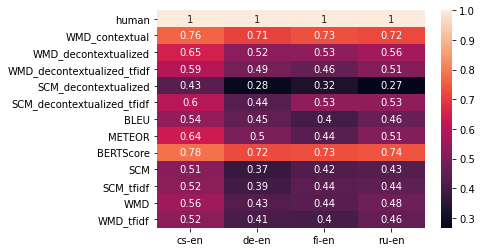

In [4]:
# Pearson
corrs_p = pd.concat([pd.DataFrame(report).corr(method="pearson").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)

<AxesSubplot:>

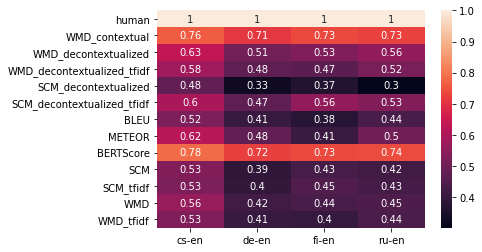

In [5]:
# Spearman
corrs_p = pd.concat([pd.DataFrame(report).corr(method="spearman").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)